<a href="https://www.kaggle.com/code/milicaradisavljevic/mobile-games-recommender?scriptVersionId=194044107" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import gensim

#vectorize the data
from sklearn.feature_extraction.text import TfidfVectorizer

#tokenize the data
import re
import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.data.path.append('/path/to/nltk_data')

#similarity metric
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# About the data

The mobile games industry has experienced explosive growth over the past decade. The industry is driven by a diverse range of genres, from puzzle and strategy to battle royale and RPGs. Mobile games are not just for casual gamers; titles like PUBG Mobile and Genshin Impact offer complex and immersive experiences. Revenue from mobile games has soared, with some games generating billions of dollars annually. In-app purchases and advertisements are the primary revenue streams for many of these games. The success of mobile games is also fueled by their accessibility, as they can be played anywhere and anytime. Social features and multiplayer modes have made mobile gaming a communal experience. The industry is also seeing innovations in augmented reality and cross-platform play. With continuous advancements in technology, the future of mobile gaming looks incredibly promising.

This is the data of 17007 strategy games on the Apple App Store. It was collected on the 3rd of August 2019, using the iTunes API and the App Store sitemap.

Dataset link: https://www.kaggle.com/datasets/tristan581/17k-apple-app-store-strategy-games

Key Attributes:
- URL;
- ID;
- Name: The name of the mobile game;
- Subtitle;
- Icon URL;
- Average User Rating: The average rating given by users who have played the mobile game;
- User Rating Count;
- Price(USD);
- In-app Purchases;
- Description: Brief description of the mobile game;
- Developer: The person who made the game;
- Age Rating;
- Languages;
- Size(Size of the app in bytes);
- Primary Genre: Main genre of the game;
- Genres: Additional informations about the genre of the mobile game;
- Original Release Date;
- Current Version Release Date.


# Objectives

- Main goal is to create a mobile game recommender system. The model successfully recommends similar mobile games based on desired mobile game. It checks if the game name exists in a list of games, computes how similar each game is to the given one, and then sorts and returns the top 5 most similar games.
- The secondary goal is to explore the data, clean it and do a basic EDA analysis.


# Load the data

In [3]:
data = pd.read_csv("/kaggle/input/17k-apple-app-store-strategy-games/appstore_games.csv")
data.head()

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017
3,https://apps.apple.com/us/app/sudoku-free/id28...,285755462,Sudoku (Free),NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017
4,https://apps.apple.com/us/app/senet-deluxe/id2...,285831220,Senet Deluxe,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018


# EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17007 entries, 0 to 17006
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   URL                           17007 non-null  object 
 1   ID                            17007 non-null  int64  
 2   Name                          17007 non-null  object 
 3   Subtitle                      5261 non-null   object 
 4   Icon URL                      17007 non-null  object 
 5   Average User Rating           7561 non-null   float64
 6   User Rating Count             7561 non-null   float64
 7   Price                         16983 non-null  float64
 8   In-app Purchases              7683 non-null   object 
 9   Description                   17007 non-null  object 
 10  Developer                     17007 non-null  object 
 11  Age Rating                    17007 non-null  object 
 12  Languages                     16947 non-null  object 
 13  S

The dataset contains 17007 entries and 18 columns. We have 13 categorical columns and 5 numerical columns. A lot of columns are not importan for us, so we will remove them in the next steps. Also, we see that we have a lot of null values that we need to solve in the future.


Average User Rating
4.5    2861
4.0    1722
5.0     990
3.5     925
3.0     514
2.5     317
2.0     158
1.5      60
1.0      14
Name: count, dtype: int64

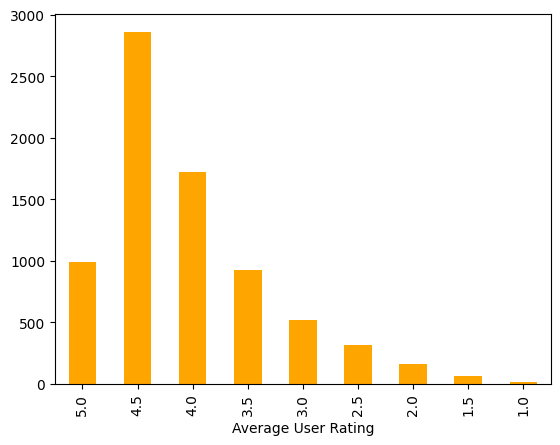

In [5]:
data["Average User Rating"].value_counts().sort_index(ascending=False).plot(kind ="bar", color="orange")
data["Average User Rating"].value_counts()

The largest number of users rated the games with a high average rating, the highest with 4.5 (2861 users), followed by 4.0 (1722 users) and 5.0 (990 users).

In [6]:
data[data['Average User Rating'] == 5.0].head()

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
160,https://apps.apple.com/us/app/slideswipe/id329...,329911028,Slideswipe,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,5.0,6.0,0.99,NaN,Slideswipe is the ultimate slide puzzle! Maste...,Plannerhead,4+,"EN, FR, DE, IT, ES",19798016.0,Games,"Games, Education, Strategy",1/04/2010,4/10/2016
185,https://apps.apple.com/us/app/king-of-dragon-p...,335545504,King of Dragon Pass,Mythic storybook strategy,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,5.0,960.0,9.99,NaN,"""Create your own epic saga of conflict, mythol...","A Sharp, LLC",12+,EN,364954624.0,Games,"Games, Entertainment, Strategy, Role Playing",14/02/2011,18/10/2018
210,https://apps.apple.com/us/app/shottactoe/id341...,341288790,ShotTacToe,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,5.0,7.0,0.99,NaN,ShotTacToe is a twist on the classic game of T...,Phone Bros,17+,EN,13151232.0,Entertainment,"Entertainment, Board, Strategy, Games",1/12/2009,22/09/2016
251,https://apps.apple.com/us/app/sync-ball/id3562...,356277312,Sync-Ball,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,5.0,37.0,0.99,NaN,"""Greetings 21st Century Earthlings!\n\nTranspo...","Tozai, Inc.",4+,EN,8821760.0,Games,"Games, Strategy, Puzzle, Education",8/03/2010,4/11/2017
275,https://apps.apple.com/us/app/worp-hd-next-gen...,364741787,WORP HD - Next Gen Solitaire Puzzle,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,5.0,5.0,1.99,NaN,"""Want to stimulate your brain, have fun and re...",Maximilian Auer,4+,"EN, DE",22065152.0,Games,"Games, Board, Strategy, Entertainment",1/04/2010,25/10/2016


Top rated games in this dataset are Slideswipe, King of Dragon Pass, ShotTacToe, Sync-Ball and WORP HD - Next Gen Solitaire Puzzle. All of them have average user rating of 5.0.

In [7]:
data["Developer"].value_counts().head(20)

Developer
Tapps Tecnologia da Informa\xe7\xe3o Ltda.    123
Vikash Patel                                  107
Netsummit Marketing, Inc.                      95
GabySoft                                       85
NetSummit Enterprises, Inc.                    77
Andrew Kudrin                                  62
MmpApps Corp.                                  61
Domyung Kim                                    57
Amy Prizer                                     46
Detention Apps                                 42
Qumaron                                        41
HexWar Games Ltd                               39
Gulfam Asghar                                  38
Lazy Days, LLC                                 37
Anthony Hindle                                 37
Tayga Games OOO                                37
8Floor                                         36
EASY Inc.                                      36
M&M App Services Pty Ltd                       36
Renato Erive                            

Above are the top 10 mobile game developers based on the number of games published. The first 3 places are:
- Tapps Tecnologia da Informa\xe7\xe3o Ltda;
- Vikash Patel;
- Netsummit Marketing, Inc.

We'will make a new column "tags" that will show us what each game is all about by combining its name, description, primary genre and genres into one big description. This helps us understand each game better and find other games that are similar to it!

In [8]:
#new column "tags"
data['tags'] = data['Name']  + data['Description'] + data['Primary Genre'] + data['Genres']

In [9]:
#removing unimportant columns
data = data.drop(["URL", "ID", "Subtitle", "Icon URL", "Languages", "User Rating Count", "Price", "In-app Purchases","Age Rating", "Size","Original Release Date", "Current Version Release Date", "Average User Rating", "Developer", "Description", "Primary Genre", "Genres"], axis=1)

In [10]:
data.head()

,Name,tags
0,Sudoku,"SudokuJoin over 21,000,000 of our fans and dow..."
1,Reversi,"ReversiThe classic game of Reversi, also known..."
2,Morocco,MoroccoPlay the classic strategy game Othello ...
3,Sudoku (Free),Sudoku (Free)Top 100 free app for over a year....
4,Senet Deluxe,"Senet Deluxe""Senet Deluxe - The Ancient Game o..."


With function clean_text we will clean and preprocess the text by converting it to lowercase, removing special characters, tokenizing into words, removing stopwords, and returning a cleaned version of the text.

In [11]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters using regex
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stopwords = set(STOPWORDS)
    filtered_tokens = [word for word in tokens if word not in stopwords]
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(filtered_tokens)
    
    return cleaned_text

In [12]:
data['tags'] = data['tags'].apply(clean_text)

In [13]:
data.head()

,Name,tags
0,Sudoku,sudokujoin fans download one sudoku games toda...
1,Reversi,reversithe classic game reversi known othello ...
2,Morocco,moroccoplay classic strategy game othello know...
3,Sudoku (Free),sudoku freetop free app yearnrated best sudoku...
4,Senet Deluxe,senet deluxesenet deluxe ancient game life aft...


In [14]:
data['tags'].iloc[3]

'sudoku freetop free app yearnrated best sudoku game year applenrated game year applenrated app year apple apps competingnnwith unique handcrafted puzzles across four different skill levels sudoku free great introduction fun puzzle solving challenge sudokunnoptionsnnall options default turn options menunu show incorrect shows incorrect answers red nu smart buttons disables number button number completed game board nu smart notes removes number notes box column row contains cell correct answernnfeaturesnnu multiple color schemesnu unique handcrafted puzzlesnu four different skill levelsnu challenge friendnu puzzles solvable without guessingnu color schemesnu notes tap notes button show possible answers square tap notes button remove notesnu hints shows answer selected square random square one selectednu pause game time resume left offnu best times progress statistics much morenndo want try one versions sudoku great featuresn look paid edition sudoku puzzles unique color schemes n try co

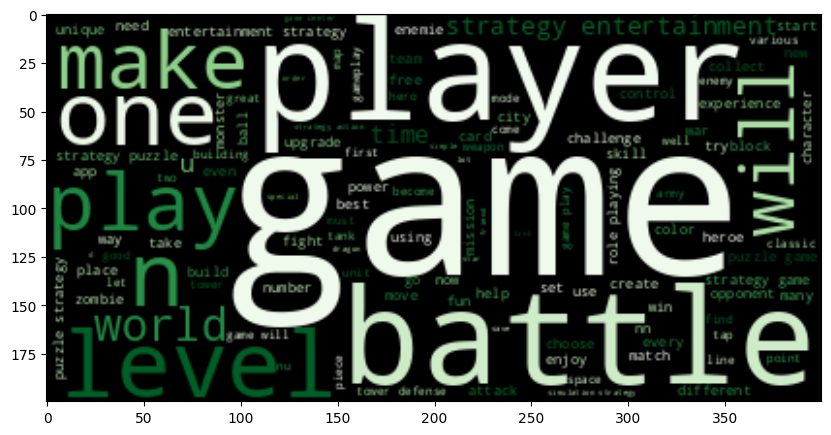

In [15]:
tag = data['tags'].values

text = ' '.join(tag)

# English Stopwords
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color='black', colormap='Greens').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In the word cloud we can see that the most frequent/important words in the tags column are: game, player, battle, level, strategy etc.

# Cosine similarity matrix

This code transforms game tags into numerical form, calculates similarity between games, and mapping game titles to indices. This preprocessing is crucial for efficiently generating game recommendations based on tags similarity.

**TfidfVectorizer()** Converts the text data in the 'tags' column into numerical vectors. TF-IDF (Term Frequency-Inverse Document Frequency) gives a measure of the importance of each word relative to other words in the dataset.

- To help our model work with text inputs, we need to convert them into a format that computers can understand. This means turning words and sentences into numerical representations. By doing this, we make it possible for the model to analyze the text and find patterns that it can use to make predictions or recommendations. This process essentially translates human language into a language that machines can process and learn from effectively.

**Cosine similarity calculation** Computes the cosine similarity between each pair of games based on their TF-IDF vectors. Cosine similarity measures the cosine of the angle between two vectors, which indicates how similar the games are to each other. This similarity matrix is used to find games that are most similar to a given game.

**Mapping Course Titles to Indices** Creates a mapping from game titles to their respective indices in the DataFrame. This allows for quick lookup of the index for any given game title, enabling efficient retrieval of similarity scores for recommendations.

In [16]:
def compute_cosine_similarity(data):
    """
    Computes the cosine similarity matrix for the games titles.
    
    Returns:
    tuple: A tuple containing the cosine similarity matrix and a mapping of game names to indices.
    """
    # Vectorization
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(data['tags'])
    
    # Cosine similarity calculation
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Mapping of course titles to indices
    indices = pd.Series(data.index, index=data['Name']).drop_duplicates()
    
    return cosine_sim, indices

In [17]:
# Compute cosine similarity matrix and indices mapping
cosine_sim, indices = compute_cosine_similarity(data)

# Recommendation Function

The recommendations function efficiently retrieves and ranks games based on their similarity to a given game name. It ensures that only valid game names are processed, retrieves similarity scores, sorts them, and returns the top recommendations.

In [18]:
def recommendations(Name):
    
    #Index Retrieval
    idx = indices[Name]
    
    #Similarity Score Calculation
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    
    #Retrieve Recommended Courses
    course_indices = [i[0] for i in sim_scores]
    return data['Name'].iloc[course_indices]

In [19]:
data['Name'].head(30)

0                             Sudoku
1                            Reversi
2                            Morocco
3                      Sudoku (Free)
4                       Senet Deluxe
5     Sudoku - Classic number puzzle
6                        Gravitation
7                             Colony
8                              Carte
9                   "Barrels O' Fun"
10                         Quaddraxx
11                        Lumen Lite
12                         BubblePop
13                            Marple
14                     Tetravex Lite
15          Awele/Oware - Mancala HD
16          Awele/Oware - Mancala HD
17                        Chess Game
18                      Catcha Mouse
19       Cool Sudoku, Jigsaw, Killer
20                  Mind the Corners
21                   All You Can Eat
22                         Ane Rouge
23                           Neiscat
24                         Boomshine
25                         Gaia Lite
26                      Fieldrunners
2

In [20]:
recommendations('Chess Game')

11950             Make It Rain: God Swipe the Queen
5185                                    Chess Royal
3897     Tossing Bills in the Club HD - Money Lover
5301         Crazy Chess Random Variant HD - BA.net
233                     Crazy Chess Random - BA.net
Name: Name, dtype: object

In [21]:
recommendations('Lux Touch 3 - World Domination')

346          Lux USA - American Civil War
15776           Lux Roman Empire Conquest
45          Lux DLX 3 - Map Conquest Game
6868     Attack Your Friends! - Risk Game
10951                         Star Engine
Name: Name, dtype: object

# Conclusion

The model successfully recommends new mobile games based on desired games. The recommendations function is designed to find and suggest games that are similar to a given game name based on their description. It checks if the game name exists in a list of games, computes how similar each game is to the given one, and then sorts and returns the top 5 most similar games.

The next step could be a more detailed cleaning of the text, specifically the "tags" column, in order to get even more precise results or to use the model for a different type of analysis.